In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Chapter 1

## Exercise 1 - Nagel-Schreckenberg traffic model
Implement the Nagel-Schreckenberg traffic model.

Every cary goes through the following steps, in parallel:
 - (1) If the velocity is $v_{max}$, increase the velocity $v$ by one unit
 - (2) If the distance to the car ahead is $d$ spaces and the current car has velocity $v\geq d$, reduce the velocity to $d-1$ to avoid collision
 - (3) If the velocity is positive, then with probability $p$ reduce it by $1$ unit.
 - (4) Move the car ahead by $v$ units

In [216]:
def simulator(M, k, v_max, p, B, num_iter, uniform_start=True):

    
    # initialize positions and velocities
    if uniform_start:
        positions = np.linspace(0, M - np.floor(M/k), num=k, dtype=int)
    else:
        positions = np.arange(0, k, dtype=int)
        
    velocities = np.zeros(k, dtype=int) # velocities initially zero. shape = (k,)


    
    road_history = np.zeros((num_iter+1, M), dtype=int)
    road_history[0, positions] = 1
    
    distance_traveled_history = np.zeros((num_iter+1, k), dtype=int)
    
    for i in range(num_iter):
        
        # if velocity lower than v_max, increment by one
        velocities[velocities < v_max] += 1
        
        # reduce velocities where necessary to avoid collisions
        car_distances = np.mod(np.diff(positions, append=positions[0]), M) # position i is distance to car i+1. Prepend and mod to enforce circular boundary conditions
        velocities[velocities >= car_distances] = car_distances[velocities >= car_distances] - 1
        
        # if velocity positive, reduce by one unit with prob p
        gen = np.random.uniform(0, 1, size=k)
        velocities[np.logical_and(velocities > 0, gen < p)] -= 1
    
        # update positions
        positions = np.mod(positions + velocities, M)
    
        # record history
        road_history[i+1, positions] = 1
        distance_traveled_history[i+1] = distance_traveled_history[i] + velocities

    return road_history, distance_traveled_history
    

In [211]:
num_iter = 2000

M = 1000 # slots on a circular road
k = 50 # number of cars
v_max = 5
p = 0.33

B = 1000 # burn in period

road_history, distance_traveled_history = simulator(M, k, v_max, p, B, num_iter)


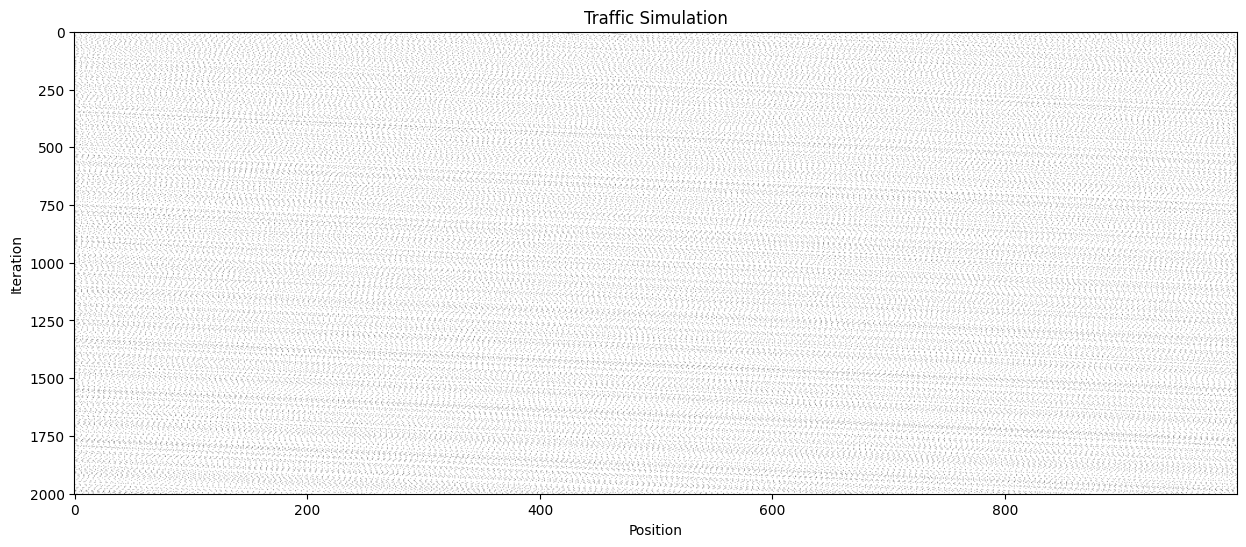

In [212]:
plt.figure(figsize=(15, 6))

plt.imshow(road_history, cmap='binary', aspect='auto')
plt.xlabel('Position')
plt.ylabel('Iteration')
plt.title('Traffic Simulation')
plt.show()

### (a) 
For $M = B = 1000$, $v_{max} = 5$, $k = 50$, and $p = 0.33$, what is the total distance traveled by the $k$ cars in their last 1000 steps (i.e., not including the burn-in)?

In [92]:
net_distance = distance_traveled_history[-1] - distance_traveled_history[B] 
np.sum(net_distance)

232747

The total distance traveled by all cars is between $232,000$ and $233,000$.

### (b)
Repeat for $k = 55$ to $k = 500$ by steps of $5$, plot total distance

In [192]:
k_vals = np.arange(55, 505, 5) 

In [193]:
num_iter = 2000

M = 1000 # slots on a circular road
v_max = 5
p = 0.33

B = 1000 # burn in period

total_net_distance = np.zeros_like(k_vals)

for i, k in enumerate(k_vals):
    road_history, distance_traveled_history = simulator(M, k, v_max, p, B, num_iter)

    net_distance = distance_traveled_history[-1] - distance_traveled_history[B] 
    total_net_distance[i] = np.sum(net_distance)

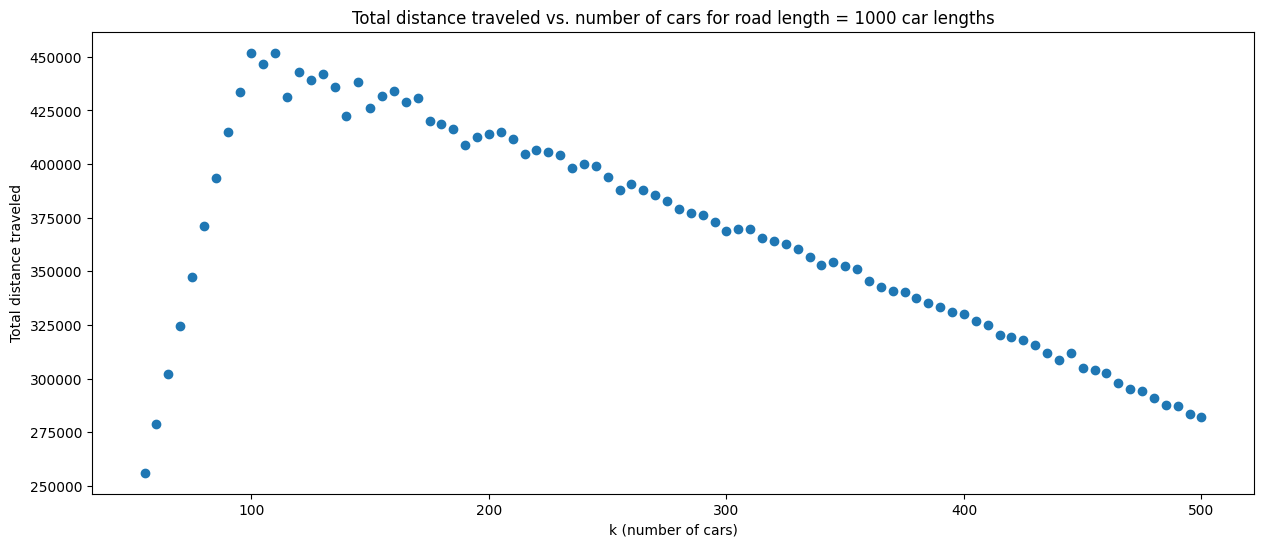

In [194]:
plt.figure(figsize=(15, 6))

plt.scatter(k_vals, total_net_distance)

plt.xlabel('k (number of cars)')
plt.ylabel('Total distance traveled')
plt.title('Total distance traveled vs. number of cars for road length = 1000 car lengths')
plt.show()

In [195]:
k_vals[total_net_distance.argmax()]

110

The value of $k$ which optimizes total distance traveled, i.e., overall flow, is $k \sim 100-110$.  Note that we are plotting total distance traveled across all cars, not total distance traveled per car. There are two competing effects. First, more cars means more objects to accumulate miles. On the flip side, more cars means more jams, so each car goes slower on average.  The optimal value of $k$ will balance these two effects.  In fact, we can see below that for the optimal $k$, there are is an appreciable number of traffic jams:

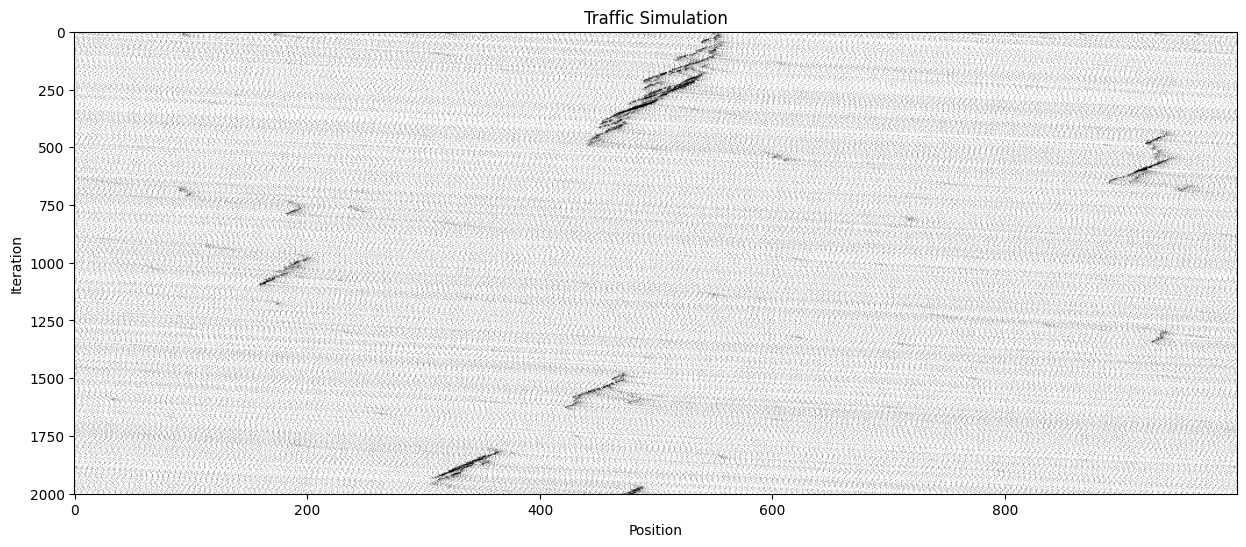

In [196]:
num_iter = 2000

M = 1000 # slots on a circular road
k = 100 # number of cars
v_max = 5
p = 0.33

B = 1000 # burn in period

road_history, distance_traveled_history = simulator(M, k, v_max, p, B, num_iter)


plt.figure(figsize=(15, 6))

plt.imshow(road_history, cmap='binary', aspect='auto')
plt.xlabel('Position')
plt.ylabel('Iteration')
plt.title('Traffic Simulation')
plt.show()

### (c)
Repeat part (b) 5 times and put on the same plot. Also show the mean, and find the 99% confidence intervals.

In [200]:
k_vals = np.arange(55, 505, 5)

num_trials = 5

num_iter = 2000

M = 1000 # slots on a circular road
v_max = 5
p = 0.33

B = 1000 # burn in period

total_net_distance = np.zeros((num_trials, k_vals.shape[0]))


for trial in range(num_trials):

    for i, k in enumerate(k_vals):
        road_history, distance_traveled_history = simulator(M, k, v_max, p, B, num_iter)
    
        net_distance = distance_traveled_history[-1] - distance_traveled_history[B] 
        total_net_distance[trial, i] = np.sum(net_distance)

average_total_net_distance = total_net_distance.mean(axis=0)
std_total_net_distance = total_net_distance.std(axis=0, ddof=1)

In [229]:
# compute 99% confidence intervals (using t distribution
lower_confidence = average_total_net_distance - 4.604*std_total_net_distance/np.sqrt(num_trials)
upper_confidence = average_total_net_distance + 4.604*std_total_net_distance/np.sqrt(num_trials)

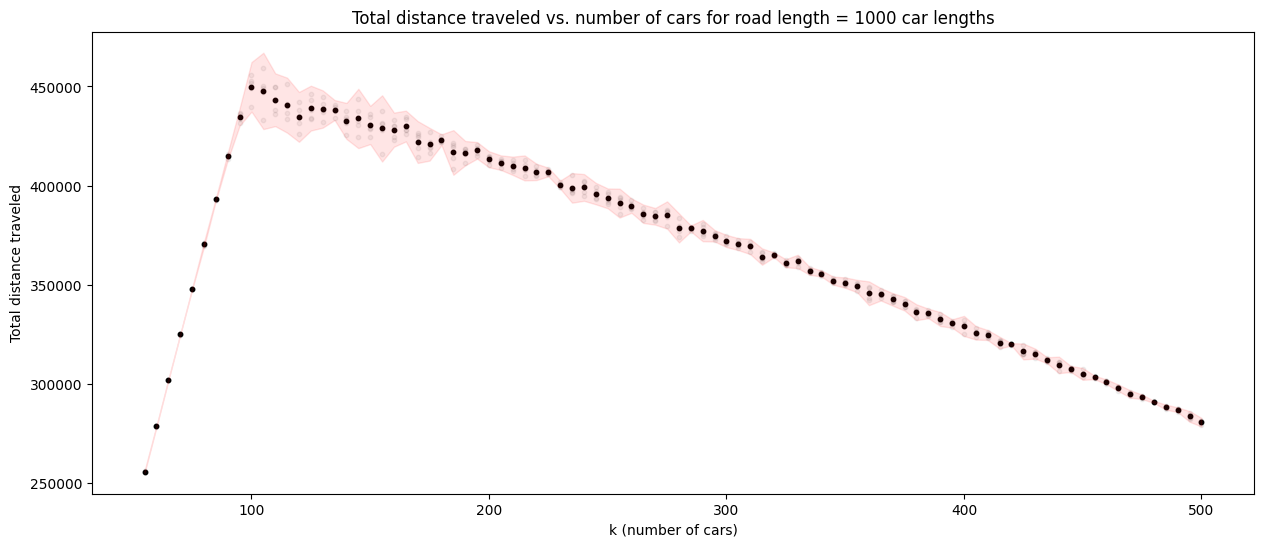

In [230]:
plt.figure(figsize=(15, 6))

for trial in range(num_trials):
    plt.scatter(k_vals, total_net_distance[trial], label='trial', color='black', s=10, alpha=0.05)

plt.scatter(k_vals, average_total_net_distance, label='mean', color='black', s=10)

plt.fill_between(k_vals, lower_confidence, upper_confidence, color='red', label='Confidence Interval', alpha=0.1)

plt.xlabel('k (number of cars)')
plt.ylabel('Total distance traveled')
plt.title('Total distance traveled vs. number of cars for road length = 1000 car lengths')
plt.show()

The $k$ values of $105-120$ have the highest flow rate.

### (d) 
Do the same thing but start the cars in positions 0 through $k-1$. Does it make a difference after the burn in?

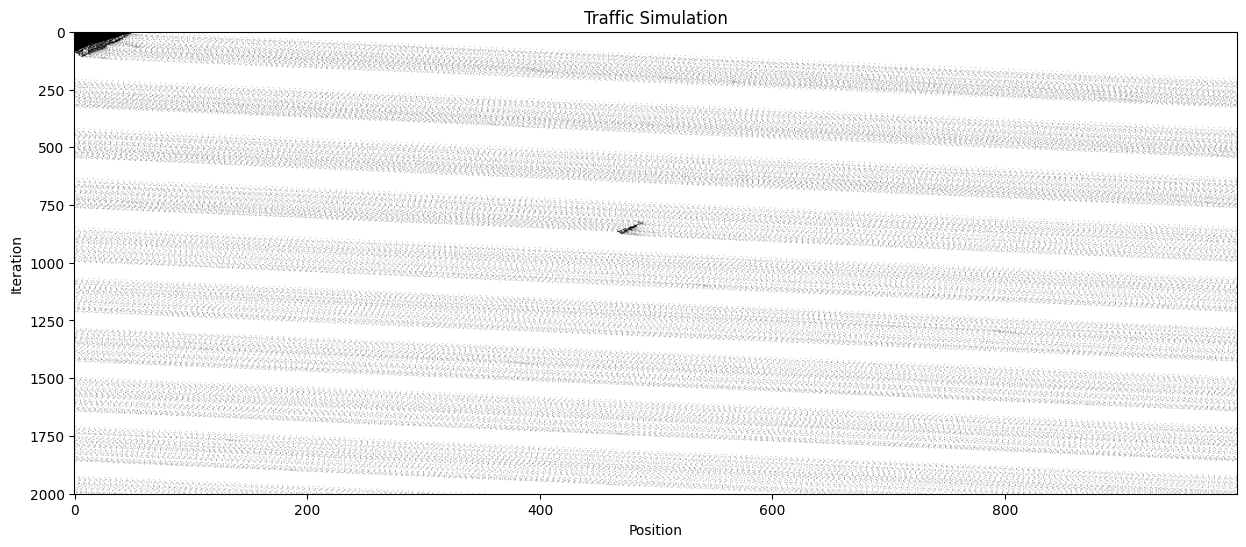

In [219]:
num_iter = 2000

M = 1000 # slots on a circular road
k = 50 # number of cars
v_max = 5
p = 0.33

B = 1000 # burn in period

road_history, distance_traveled_history = simulator(M, k, v_max, p, B, num_iter, uniform_start=False)

plt.figure(figsize=(15, 6))

plt.imshow(road_history, cmap='binary', aspect='auto')
plt.xlabel('Position')
plt.ylabel('Iteration')
plt.title('Traffic Simulation')
plt.show()

When the density of cars is low, they basically don't interact with each other, so they all move at roughly the same rate, creating the bands above.  However when we increase the density, we see more interactions, and after the burn in the situation is pretty indistinguishable from the prior scenario

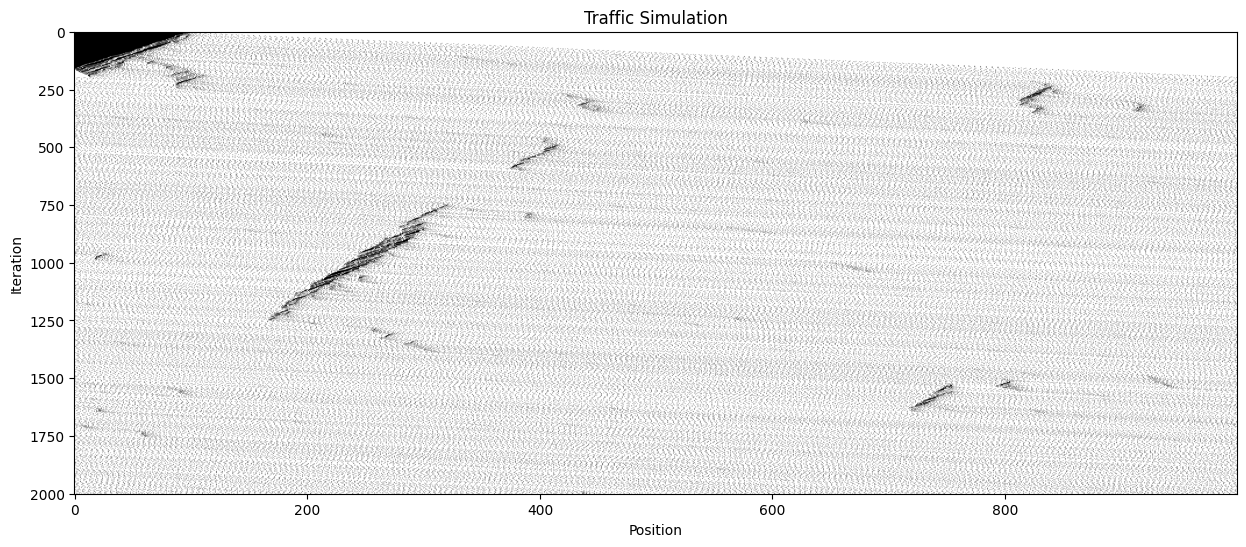

In [226]:
num_iter = 2000

M = 1000 # slots on a circular road
k = 100 # number of cars
v_max = 5
p = 0.33

B = 1000 # burn in period

road_history, distance_traveled_history = simulator(M, k, v_max, p, B, num_iter, uniform_start=False)

plt.figure(figsize=(15, 6))

plt.imshow(road_history, cmap='binary', aspect='auto')
plt.xlabel('Position')
plt.ylabel('Iteration')
plt.title('Traffic Simulation')
plt.show()

Now let's check if our phase diagram looks any different

In [221]:
k_vals = np.arange(55, 505, 5)

num_trials = 5

num_iter = 2000

M = 1000 # slots on a circular road
v_max = 5
p = 0.33

B = 1000 # burn in period

total_net_distance = np.zeros((num_trials, k_vals.shape[0]))


for trial in range(num_trials):

    for i, k in enumerate(k_vals):
        road_history, distance_traveled_history = simulator(M, k, v_max, p, B, num_iter)
    
        net_distance = distance_traveled_history[-1] - distance_traveled_history[B] 
        total_net_distance[trial, i] = np.sum(net_distance)

average_total_net_distance = total_net_distance.mean(axis=0)
std_total_net_distance = total_net_distance.std(axis=0, ddof=1)

In [227]:
# compute 99% confidence intervals (using t distribution
lower_confidence = average_total_net_distance - 4.604*std_total_net_distance/np.sqrt(num_trials)
upper_confidence = average_total_net_distance + 4.604*std_total_net_distance/np.sqrt(num_trials)

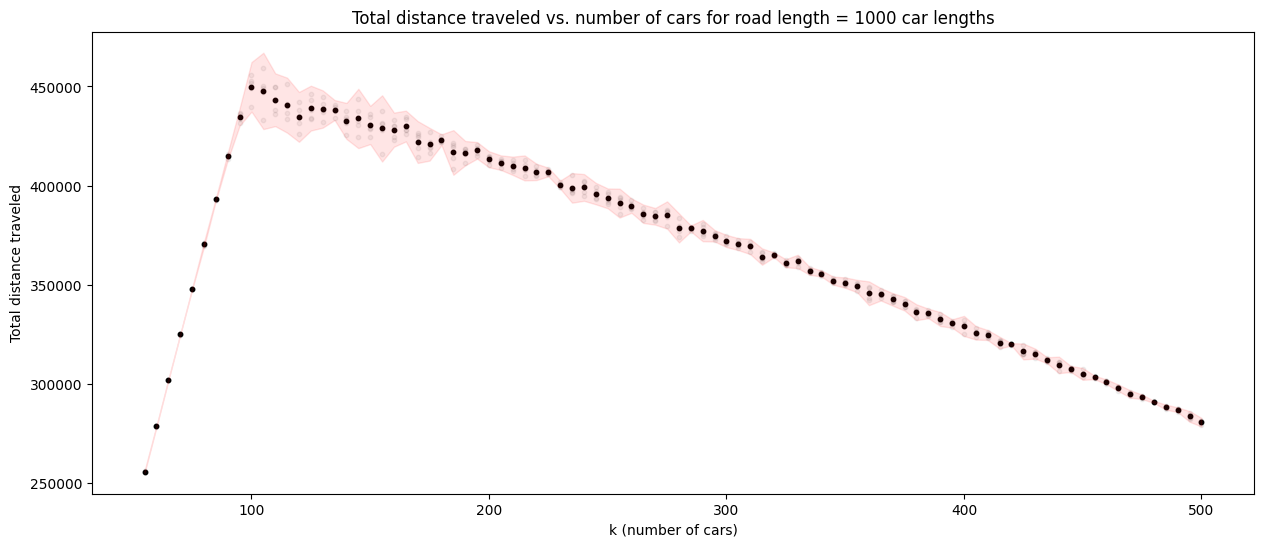

In [228]:
plt.figure(figsize=(15, 6))

for trial in range(num_trials):
    plt.scatter(k_vals, total_net_distance[trial], label='trial', color='black', s=10, alpha=0.05)

plt.scatter(k_vals, average_total_net_distance, label='mean', color='black', s=10)

plt.fill_between(k_vals, lower_confidence, upper_confidence, color='red', label='Confidence Interval', alpha=0.1)

plt.xlabel('k (number of cars)')
plt.ylabel('Total distance traveled')
plt.title('Total distance traveled vs. number of cars for road length = 1000 car lengths')
plt.show()

Not really. This makes sense because prior to the critical density, the cars aren't interacting anyway, so where they start doesn't affect their total distance. Then beyond the critical density, the traffic simulation plots look fairly similar after the burn-in period.  